# Load raw images, preprocess, convert to time series format, save to disk

In [1]:
from volTools import getStackDims
from glob import glob
import numpy as np
from scipy.ndimage.filters import percentile_filter
from thunder import Registration

### Specify the raw directories (input) and series directories (output)

In [2]:
rawDirs = ['/nobackup/ahrens/davis/data/raw/20150616/4dpf_cy163xcy221_F2_omr_1_20150616_225359/CHN00/',
          '/nobackup/ahrens/davis/data/raw/20150616/4dpf_cy163xcy221_F2_omr_1_20150616_225359/CHN01/']

serDirs = ['/nobackup/ahrens/davis/data/spark/20150616/4dpf_cy163xcy221_F2_omr_1_20150616_225359/CHN00/series/',
           '/nobackup/ahrens/davis/data/spark/20150616/4dpf_cy163xcy221_F2_omr_1_20150616_225359/CHN01/series/']

In [10]:
curExp = 1

rawDir = rawDirs[curExp]
serDir = serDirs[curExp]

### Register images, estimate dff, save to disk

In [11]:
# length of reference for registration, in frames
refLength = 20

# parameters for dff estimation:
# percentile to use as baseline
perc = 15
# window size for sliding baseline estimation
window = 100

# get number of images
nImages = len(glob(rawDir + '*.stack'))

# get image dimensions
dims = getStackDims(rawDir)

# prepare image data
imDat = tsc.loadImages(rawDir, dims, ext='stack', npartitions=nImages)

# reference timerange
refR = (nImages / 2) + np.array([-refLength/2, refLength/2])

# crop data, only registering on the middle 9th of each plane
cropped = imDat.crop((dims[0]/3, dims[1]/3, 0), (2 * dims[0]/3, 2* dims[1]/3, dims[2]))

# make reference
regCrop = Registration('planarcrosscorr').prepare(cropped, startIdx=refR[0], stopIdx=refR[1])

# estimate registration parameters on median filtered data
regParams = regCrop.fit(cropped.medianFilter(3))

# apply registration to median filtered data
regDat = regParams.transform(imDat.medianFilter(3))

# convert data to timeseries format
serDat = regDat.toTimeSeries().cache()

# define a dff function to be called for all timeseries
baseFunc = lambda x: percentile_filter(x.astype('float64'), perc, window, mode='reflect')    

def dff(y):
    b = baseFunc(y)
    return (y - b) / (b + 0.1)

# calculate dff
dffDat = serDat.applyValues(dff, keepIndex=True)

# save to disk
dffDat.saveAsBinarySeries(serDir, overwrite=True)

### Check the effect of dff estimation

In [12]:
rawMean = serDat.mean()
dffMean = dffDat.mean()

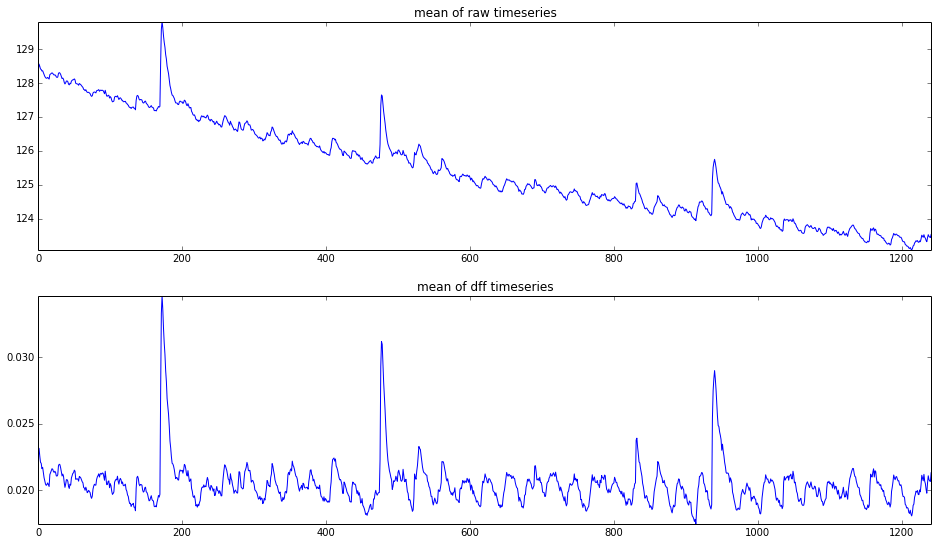

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,9))
plt.subplot(211)
plt.plot(rawMean)
plt.title('mean of raw timeseries')
plt.axis('tight')

plt.subplot(212)
plt.plot(dffMean)
plt.axis('tight')
plt.title('mean of dff timeseries')

# How are these data stored?

### The `conf.json` file explains the structure of the data stored in the `.bin` files

The binary data in the .bin files is divided into chunks with length = `nkeys + nvalues`. 

`nkeys` is usually 3 (for `(x, y, z)` coordinates)

`nvalues` is the number of timepoints in the experiment. There is no structure encoded in the number of `.bin` files.  


In [14]:
import json
from pprint import pprint

conf = serDirs[0] + 'conf.json'

with open(conf) as data_file:    
    data = json.load(data_file)

pprint(data)

{u'input': u'/nobackup/ahrens/davis/data/spark/20150616/4dpf_cy163xcy221_F2_omr_1_20150616_225359/CHN00/series/',
 u'keytype': u'int16',
 u'nkeys': 3,
 u'nvalues': 1242,
 u'valuetype': u'float64'}
